In [4]:
import uproot
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import progressbar
from scipy.interpolate import interp1d

In [5]:
calcValues = False

## Berechnung der Integralmatrix 

In [ ]:
mainPath = "/nfs/freenas/tuph/e18/project/compass/analysis/tkumschier/ROOTPWA/test/TEST_FOLDER_MASS/"
testFoldersTmp = []
for filename in sorted(os.listdir(mainPath)):
    testFoldersTmp.append(filename)
testFolders = (np.sort(np.array(testFoldersTmp).astype(int))).astype(str)

In [ ]:
def prepareArray(origArray):
    preparedArray = np.zeros(len(origArray), dtype=complex)
    for i in range(0, len(origArray)):
        preparedArray[i] = origArray[i][0]
    return preparedArray

In [ ]:
nmbTestFolders = len(testFolders)

nmbWaves = len([name for name in os.listdir(mainPath + testFolders[0] + '/amps/') if os.path.isfile(os.path.join(mainPath + testFolders[0] + '/amps/', name))])
axisArr = np.zeros(nmbTestFolders, dtype=int)
integralMatrix = np.zeros((nmbWaves, nmbWaves), dtype = np.ndarray)
errorMatrixAbsolut = np.zeros((nmbWaves, nmbWaves), dtype = np.ndarray)
errorMatrixRelativ = np.zeros((nmbWaves, nmbWaves), dtype = np.ndarray)
for i in range(0, nmbWaves):
    for j in range(0, nmbWaves):
        integralMatrix[i][j] = np.zeros(nmbTestFolders, dtype=complex)
        errorMatrixAbsolut[i][j] = np.zeros(nmbTestFolders, dtype=complex)
        errorMatrixRelativ[i][j] = np.zeros(nmbTestFolders, dtype=complex)


bar = progressbar.ProgressBar(maxval=nmbTestFolders, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for folderI in range(0,nmbTestFolders):
    ampPath = mainPath + testFolders[folderI] + '/amps/'
    bar.update(folderI+1)
    #print testFolders[folderI][16:]
    axisArr[folderI] = testFolders[folderI]




    onlyfiles = []
    for filename in sorted(os.listdir(ampPath)):
        onlyfiles.append(filename)
    nmbWaves = len(onlyfiles)
    ampFile1 = uproot.open(ampPath + onlyfiles[0])
    nmbEvents = len(ampFile1[ampFile1.keys()[0]]['amplitude'].get('_incohSubAmps._real').array())
    sd = np.zeros((nmbWaves, nmbWaves), dtype = complex)
    ampMatrix = np.zeros((nmbWaves,nmbEvents), dtype = complex)



    for waveIndexI in range(0, nmbWaves):
        if ampMatrix[waveIndexI].all() == 0:
            ampFile1 = uproot.open(ampPath + onlyfiles[waveIndexI])
            key1 = ampFile1.keys()[0]

            incohSubAmpsReal1 = ampFile1[key1]['amplitude'].get('_incohSubAmps._real').array()
            incohSubAmpsImag1 = ampFile1[key1]['amplitude'].get('_incohSubAmps._imag').array()
            ampMatrix[waveIndexI] = prepareArray(np.array(incohSubAmpsReal1 + 1j * incohSubAmpsImag1))
            #print ampMatrix[waveIndexI]
            #raise ValueError('Exit.')




        for waveIndexJ in range(0, waveIndexI + 1): #nmbWaves):
            if ampMatrix[waveIndexJ].all() == 0:
                ampFile2 = uproot.open(ampPath + onlyfiles[waveIndexJ])
                key2 = ampFile2.keys()[0]

                incohSubAmpsReal2 = ampFile2[key2]['amplitude'].get('_incohSubAmps._real').array()
                incohSubAmpsImag2 = ampFile2[key2]['amplitude'].get('_incohSubAmps._imag').array()
                ampMatrix[waveIndexJ] = prepareArray(np.array(incohSubAmpsReal2 + 1j * incohSubAmpsImag2))

            integral = np.sum(ampMatrix[waveIndexI] * ampMatrix[waveIndexJ].conjugate())/nmbEvents 

            sdReal = sum(pow((ampMatrix[waveIndexI] * ampMatrix[waveIndexJ].conjugate()).real, 2)).real
            sdImag = sum(pow((ampMatrix[waveIndexI] * ampMatrix[waveIndexJ].conjugate()).imag, 2)).real
            #print "Var1:", sdReal
            
            
            sdReal = math.sqrt(sdReal/float(nmbEvents) - pow(integral.real,2))
            sdImag = math.sqrt(sdImag/float(nmbEvents) - pow(integral.imag,2))
            sdComplex = complex(sdReal, sdImag)        
            errorComplex = complex(sdReal/math.sqrt(nmbEvents), sdImag/math.sqrt(nmbEvents))

            sd[waveIndexI][waveIndexJ] = sdComplex
            sd[waveIndexJ][waveIndexI] = sdComplex
   
            #print "%i, %i, %i: %s, %s, %s" %(folderI, waveIndexI, waveIndexJ, integral, sd[waveIndexI][waveIndexJ], errorComplex)
            #print np.cov(amp/nmbEvents)
            #raise ValueError('Exit.')

            integralMatrix[waveIndexI][waveIndexJ][folderI] = integral
            errorMatrixAbsolut[waveIndexI][waveIndexJ][folderI] = errorComplex
            errorMatrixAbsolut[waveIndexJ][waveIndexI][folderI] = errorComplex

            if waveIndexI == waveIndexJ:
                errorMatrixRelativ[waveIndexI][waveIndexJ][folderI] = complex(errorComplex.real/math.fabs(integral.real), 0)
            else:
                errorMatrixRelativ[waveIndexI][waveIndexJ][folderI] = complex(errorComplex.real/math.fabs(integral.real), errorComplex.imag/math.fabs(integral.imag))
                errorMatrixRelativ[waveIndexJ][waveIndexI][folderI] = complex(errorComplex.real/math.fabs(integral.real), errorComplex.imag/math.fabs(integral.imag))


print "Finish calculation successfully"

In [ ]:
if calcValues == True:
    fileName = 'Fehler_bei_unterschiedlicher_Masse_Auswertung_500_3000_100.npy'
    np.save(fileName, np.array([(axisArr, onlyfiles, integralMatrix, errorMatrixAbsolut, errorMatrixRelativ)]))
    print "Finish application successfully to file:", fileName

# Auswertung
## Lade Daten

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
calcValues = False

In [2]:
if calcValues == False:
    axisArr20, onlyfiles, integralMatrix, errorMatrixAbsolut, errorMatrixRelativ = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_3000_20.npy')[0]
    axisArr60, _, integralMatrix1, errorMatrixAbsolut1, errorMatrixRelativ1 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_3020_60.npy')[0]
    axisArr100, _, integralMatrix2, errorMatrixAbsolut2, errorMatrixRelativ2 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_3000_100.npy')[0]
    axisArr80, _, integralMatrix3, errorMatrixAbsolut3, errorMatrixRelativ3 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_2900_80.npy')[0]
    #axisArr1, _, integralMatrix4, errorMatrixAbsolut4, errorMatrixRelativ4 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_1200_1300_1.npy')[0]
    axisArr1, _, integralMatrix4, errorMatrixAbsolut4, errorMatrixRelativ4 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_1200_1430_1.npy')[0]
    axisArr10, _, integralMatrix5, errorMatrixAbsolut5, errorMatrixRelativ5 = np.load('Fehler_bei_unterschiedlicher_Masse_Auswertung_500_1600_10.npy')[0]


    axisArr20 = axisArr20[:-5]
    axisArr60 = axisArr60[:-2]
    axisArr100 = axisArr100[:-1]

    for i in range(0,len(errorMatrixAbsolut)):
        for j in range(0, len(errorMatrixAbsolut)):    
            integralMatrix[i,j] = integralMatrix[i,j][:-5]
            integralMatrix1[i,j] = integralMatrix1[i,j][:-2]
            integralMatrix2[i,j] = integralMatrix2[i,j][:-1]
            
            errorMatrixAbsolut[i,j] = errorMatrixAbsolut[i,j][:-5]
            errorMatrixAbsolut1[i,j] = errorMatrixAbsolut1[i,j][:-2]
            errorMatrixAbsolut2[i,j] = errorMatrixAbsolut2[i,j][:-1]
            
            errorMatrixRelativ[i,j] = errorMatrixRelativ[i,j][:-5]
            errorMatrixRelativ1[i,j] = errorMatrixRelativ1[i,j][:-2]
            errorMatrixRelativ2[i,j] = errorMatrixRelativ2[i,j][:-1]

            

## Plotte Daten
1. Integralwerte
2. Absolute Fehler
3. Relative Fehler

0 0
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


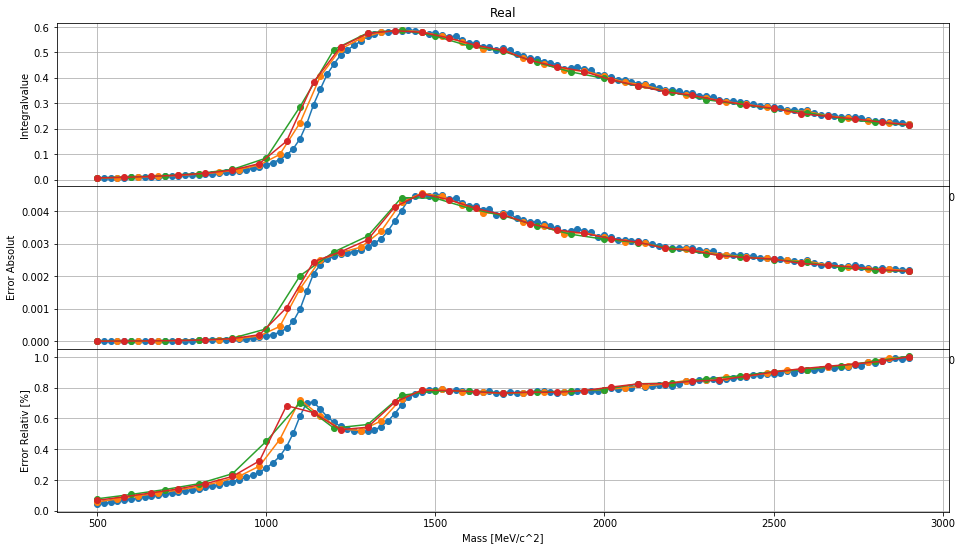

In [33]:
if calcValues == False:
    for i in range(0,1): #len(errorMatrixAbsolut)):
        for j in range(0, i+1):
            print i, j
            print onlyfiles[i]
            print onlyfiles[j]
            
            f = plt.figure(figsize=(16,9))
            plt.subplots_adjust(hspace=0.001)

            ax1 = plt.subplot(311)
            ax1.grid(True)
            ax1.plot(axisArr, integralMatrix[i][j].real, 'o-')
            ax1.plot(axisArr1, integralMatrix1[i][j].real, 'o-')
            ax1.plot(axisArr2, integralMatrix2[i][j].real, 'o-')
            ax1.plot(axisArr3, integralMatrix3[i][j].real, 'o-')
            plt.title("Real")
            plt.ylabel('Integralvalue')

            ax2 = plt.subplot(312, sharex=ax1)
            ax2.grid(True)
            ax2.plot(axisArr, errorMatrixAbsolut[i][j].real, 'o-')
            ax2.plot(axisArr1, errorMatrixAbsolut1[i][j].real, 'o-')
            ax2.plot(axisArr2, errorMatrixAbsolut2[i][j].real, 'o-')
            ax2.plot(axisArr3, errorMatrixAbsolut3[i][j].real, 'o-')
            plt.ylabel('Error Absolut')

            ax3 = plt.subplot(313, sharex=ax1)
            ax3.grid(True)
            ax3.plot(axisArr,  100 * errorMatrixRelativ[i][j].real, 'o-')
            ax3.plot(axisArr1, 100 * errorMatrixRelativ1[i][j].real, 'o-')
            ax3.plot(axisArr2, 100 * errorMatrixRelativ2[i][j].real, 'o-')
            ax3.plot(axisArr3, 100 * errorMatrixRelativ3[i][j].real, 'o-')
            plt.xlabel('Mass [MeV/c^2]')
            plt.ylabel('Error Relativ [%]')

            plt.show()
            
            if i != j:
                print onlyfiles[i]
                print onlyfiles[j]
                
                f = plt.figure(figsize=(16,9))
                plt.subplots_adjust(hspace=0.001)

                ax1 = plt.subplot(311)
                ax1.grid(True)
                ax1.plot(axisArr, integralMatrix[i][j].imag, 'o-')
                ax1.plot(axisArr1, integralMatrix1[i][j].imag, 'o-')
                ax1.plot(axisArr2, integralMatrix2[i][j].imag, 'o-')
                ax1.plot(axisArr3, integralMatrix3[i][j].imag, 'o-')
                plt.title("Imag")
                plt.ylabel('Integralvalue')

                ax2 = plt.subplot(312, sharex=ax1)
                ax2.grid(True)
                ax2.plot(axisArr, errorMatrixAbsolut[i][j].imag, 'o-')
                ax2.plot(axisArr1, errorMatrixAbsolut1[i][j].imag, 'o-')
                ax2.plot(axisArr2, errorMatrixAbsolut2[i][j].imag, 'o-')
                ax2.plot(axisArr3, errorMatrixAbsolut3[i][j].imag, 'o-')
                plt.ylabel('Error Absolut')

                ax3 = plt.subplot(313, sharex=ax1)
                ax3.grid(True)
                ax3.plot(axisArr,  100 * errorMatrixRelativ[i][j].imag, 'o-')
                ax3.plot(axisArr1, 100 * errorMatrixRelativ1[i][j].imag, 'o-')
                ax3.plot(axisArr2, 100 * errorMatrixRelativ2[i][j].imag, 'o-')
                ax3.plot(axisArr3, 100 * errorMatrixRelativ3[i][j].imag, 'o-')
                plt.xlabel('Mass [MeV/c^2]')
                plt.ylabel('Error Relativ [%]')

                plt.show()
                
                
                
    

## Interpolation

In [ ]:
from scipy.stats import chisquare

In [ ]:
def plotInterpolateError(ax, axisArrInterpolate, realRootMatrix, realRootMatrixSep, realMatrix, f, f1, f2, f3, f4, binBreite):
            #ax.plot(axisArrInterpolate, realMatrix[i,j].real-(realRootMatrix[i][j][::realRootMatrixSep].real + f(axisArrInterpolate)/60*100), 'x--', color='dodgerblue')
            #ax.plot(axisArrInterpolate, realMatrix[i,j].real-(realRootMatrix[i][j][::realRootMatrixSep].real + f1(axisArrInterpolate)/60*100), 'x--', color='black')
            #ax.plot(axisArrInterpolate, realMatrix[i,j].real-(realRootMatrix[i][j][::realRootMatrixSep].real + f2(axisArrInterpolate)/60*100), 'x--', color='grey')
            #ax.plot(axisArrInterpolate, realMatrix[i,j].real-(realRootMatrix[i][j][::realRootMatrixSep].real + f3(axisArrInterpolate)/60*100), 'x--', color='green')
            #ax.plot(axisArrInterpolate, realMatrix[i,j].real-(realRootMatrix[i][j][::realRootMatrixSep].real + f4(axisArrInterpolate)/60*100), 'x-.', color='blue')

            ax.plot(axisArrInterpolate, np.fabs((realMatrix[i,j].real-(realRootMatrix[i][j][::realRootMatrixSep].real + f(axisArrInterpolate)/60*100))/realMatrix[i,j].real), 'x:', color='dodgerblue')
            ax.plot(axisArrInterpolate, np.fabs((realMatrix[i,j].real-(realRootMatrix[i][j][::realRootMatrixSep].real + f1(axisArrInterpolate)/60*100))/realMatrix[i,j].real), 'x:', color='orangered')
            #ax.plot(axisArrInterpolate, np.fabs((realMatrix[i,j].real-(realRootMatrix[i][j][::realRootMatrixSep].real + f2(axisArrInterpolate)/60*100))/realMatrix[i,j].real), 'x:', color='fuchsia')
            #ax.plot(axisArrInterpolate, np.fabs((realMatrix[i,j].real-(realRootMatrix[i][j][::realRootMatrixSep].real + f3(axisArrInterpolate)/60*100))/realMatrix[i,j].real), 'x:', color='black')
            #ax.plot(axisArrInterpolate, np.fabs((realMatrix[i,j].real-(realRootMatrix[i][j][::realRootMatrixSep].real + f4(axisArrInterpolate)/60*100))/realMatrix[i,j].real), 'x:', color='fuchsia')

            print binBreite, chisquare((realRootMatrix[i][j][::realRootMatrixSep].real + f(axisArrInterpolate)/60*100).real, f_exp=realMatrix[i,j].real)
            print binBreite, chisquare((realRootMatrix[i][j][::realRootMatrixSep].real + f1(axisArrInterpolate)/60*100).real, f_exp=realMatrix[i,j].real)
            #print binBreite, chisquare((realRootMatrix[i][j][::realRootMatrixSep].real + f2(axisArrInterpolate)/60*100).real, f_exp=realMatrix[i,j].real)
            #print binBreite, chisquare((realRootMatrix[i][j][::realRootMatrixSep].real + f3(axisArrInterpolate)/60*100).real, f_exp=realMatrix[i,j].real)
            #print binBreite, chisquare((realRootMatrix[i][j][::realRootMatrixSep].real + f4(axisArrInterpolate)/60*100).real, f_exp=realMatrix[i,j].real)
                        


In [ ]:
if calcValues == False:
    
    matrix = integralMatrix
    matrix1 = integralMatrix1
    matrix2 = integralMatrix2
    matrix3 = integralMatrix3
    
    xmin = min(axisArr)-100; xmax = max(axisArr)+100
    #xmin = 400; xmax = 1900
    
    
    for i in range(0,5):#len(errorMatrixAbsolut)):
        for j in range(0, i+1):
            print i, j
            print onlyfiles[i]
            print onlyfiles[j]
            
            f = plt.figure(figsize=(16,20))
            plt.subplots_adjust(hspace=0.001)
            
            ax1 = plt.subplot(311)
            ax1.grid(True)     
            ax1.set_xlim(xmin, xmax)
            #ax1.set_xticks([])
            ax1.set_ylabel('Integralwert')
            axisArr60Interpoliert = axisArr1[:-1]
            axisArr100Interpoliert = axisArr2[:-1]
            axisArr80Interpoliert = axisArr3[:-1]
            matrix60Interpoliert = np.zeros(len(matrix[i,j])/3)
            matrix100Interpoliert = np.zeros(len(matrix[i,j])/5)
            matrix80Interpoliert = np.zeros(len(matrix[i,j])/4)
            for k in range(0, len(matrix[i,j])/3):
                matrix60Interpoliert[k] = (matrix[i,j][3*k].real + matrix[i,j][3*k+1].real + matrix[i,j][3*k+2].real)/3
            for k in range(0, len(matrix[i,j])/5):
                matrix100Interpoliert[k] = (matrix[i,j][5*k].real + matrix[i,j][5*k+1].real + matrix[i,j][5*k+2].real + matrix[i,j][5*k+3].real + matrix[i,j][5*k+4].real)/5
            for k in range(0, len(matrix[i,j])/4):
                matrix80Interpoliert[k] = (matrix[i,j][4*k].real + matrix[i,j][4*k+1].real + matrix[i,j][4*k+2].real + matrix[i,j][4*k+3].real)/4


            ax1.plot(axisArr,  matrix[i][j].real,  'o--', color='dodgerblue', label='20')
            ax1.plot(axisArr1, matrix1[i][j].real, 'o--', color='orangered', label='60')
            ax1.plot(axisArr60Interpoliert,  matrix60Interpoliert.real,  'o:', color='orangered');
            
            ax1.plot(axisArr1, matrix1[i][j].real, 'o--', color='fuchsia', label='100')
            ax1.plot(axisArr100Interpoliert,  matrix100Interpoliert.real,  'o:', color='fuchsia')
            
            ax1.plot(axisArr1, matrix1[i][j].real, 'o--', color='green')
            ax1.plot(axisArr80Interpoliert,  matrix80Interpoliert.real,  'o:', color='green', label='80')

            #ax1.plot(axisArr2, matrix2[i][j].real, 'o--', color='fuchsia')
            #ax1.plot(axisArr3, matrix3[i][j].real, 'o--', color='green')
            ax1.legend();

            

            ax2 = plt.subplot(312, sharex=ax1)
            ax2.grid(True)
            ax2.set_xlim(xmin, xmax)
            ax2.set_ylabel('Fehler [%]')
            ax2.plot(axisArr60Interpoliert,  100 * (matrix60Interpoliert.real  - matrix1[i,j][:-1].real)/matrix1[i,j][:-1].real, 'o--', color='orangered', label='60')
            ax2.plot(axisArr100Interpoliert, 100 * (matrix100Interpoliert.real - matrix2[i,j][:-1].real)/matrix2[i,j][:-1].real, 'o--', color='fuchsia', label='100')
            ax2.plot(axisArr80Interpoliert,  100 * (matrix80Interpoliert.real  - matrix3[i,j][:-1].real)/matrix3[i,j][:-1].real, 'o--', color='green', label='80')
            ax2.legend()
            
            plt.show()
            
            

## Berechnung der Daten durch Summation von feineres Binning

In [49]:
def calcMatrixFromFineToRough(origAxisArr, origRootMatrix, origErrorMatrix, nmb):  
    #if nmb%2 == 0:
    matrixInterpoliert = np.zeros(len(origRootMatrix[i,j])/nmb)
    matrixErrorAbsolut = np.zeros(len(origRootMatrix[i,j])/nmb)
    axisArr = origAxisArr[:-1]
    for k in range(0, len(origRootMatrix[i,j])/nmb):
        tmp = 0
        for l in range(0, nmb):
            tmp += origRootMatrix[i,j][nmb*k+l].real
        matrixInterpoliert[k] = tmp/nmb
        matrixErrorAbsolut[k] = np.std(origErrorMatrix[i,j][nmb*k:nmb*k+nmb-1])/math.sqrt(nmb)
    '''      
    else:
        matrixInterpoliert = np.zeros(len(matrix20[i,j])/nmb-1)
        axisArr = origAxisArr[1:-1]
        for k in range(1, len(matrix20[i,j])/nmb):
            tmp = 0
            for l in range(-(nmb-1)/2, (nmb+1)/2):
                tmp += origMatrix[i,j][nmb*k+l].real
            matrixInterpoliert[k-1] = tmp/nmb
    '''
    return axisArr, matrixInterpoliert, matrixErrorAbsolut

### Grundlage 20 MeV Bin

0 0
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


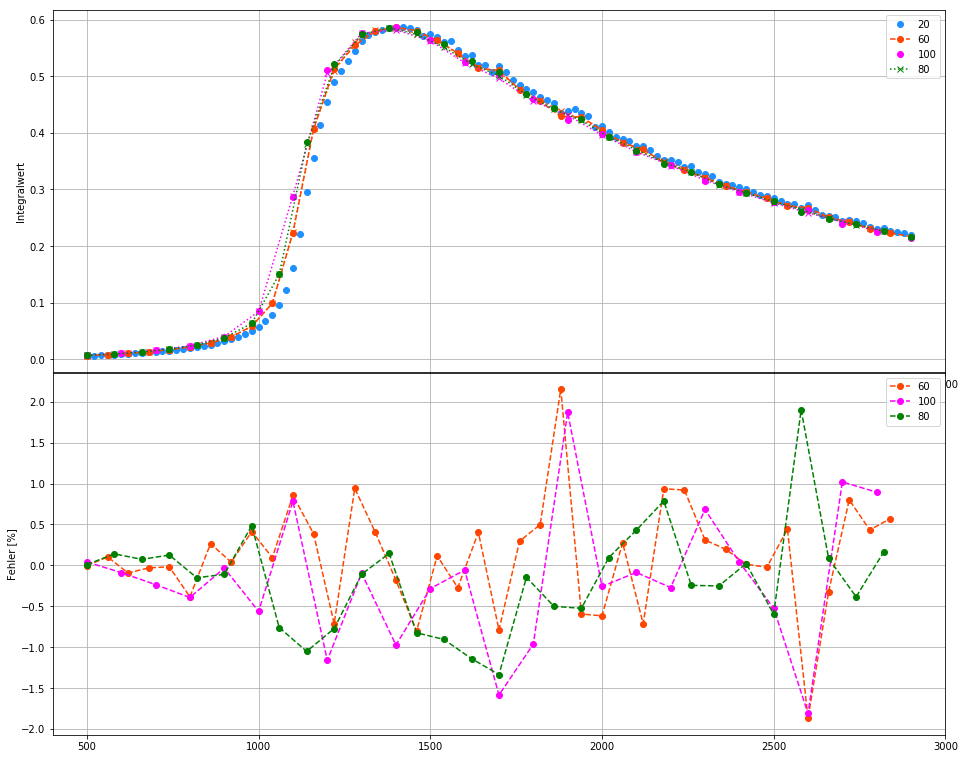

1 0
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


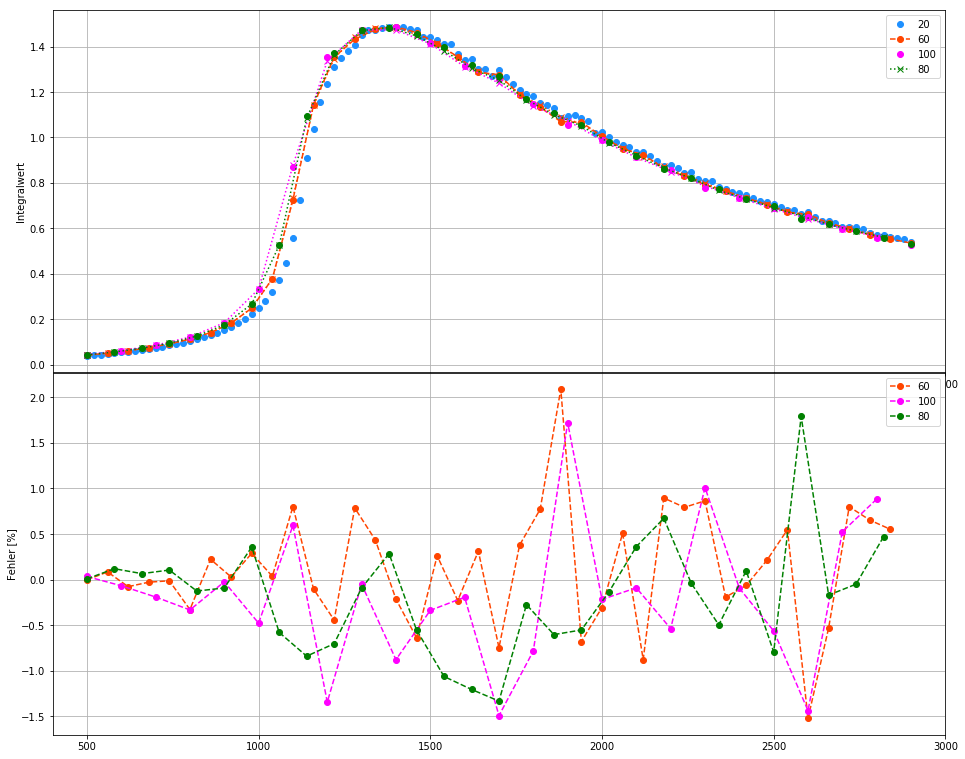

1 1
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


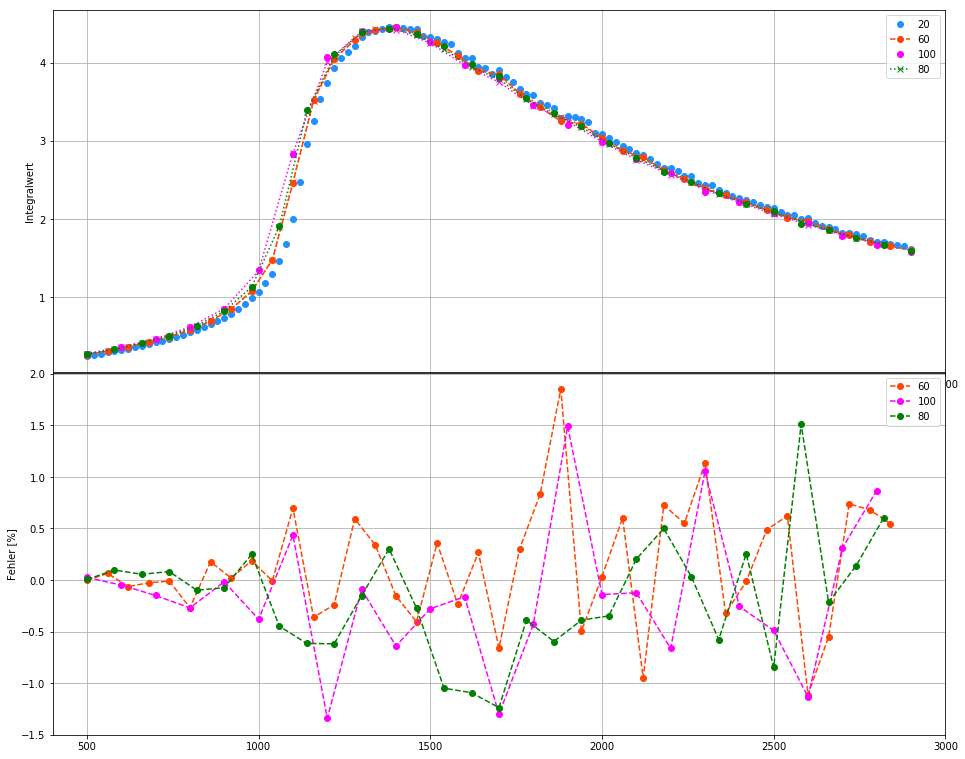

2 0
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


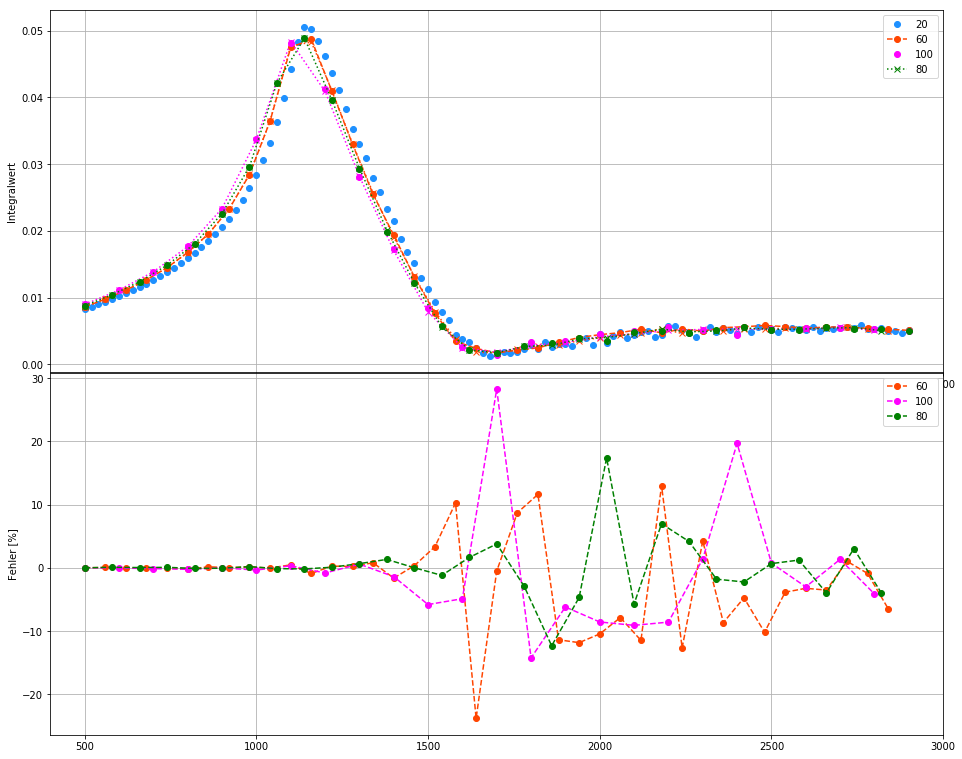

2 1
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


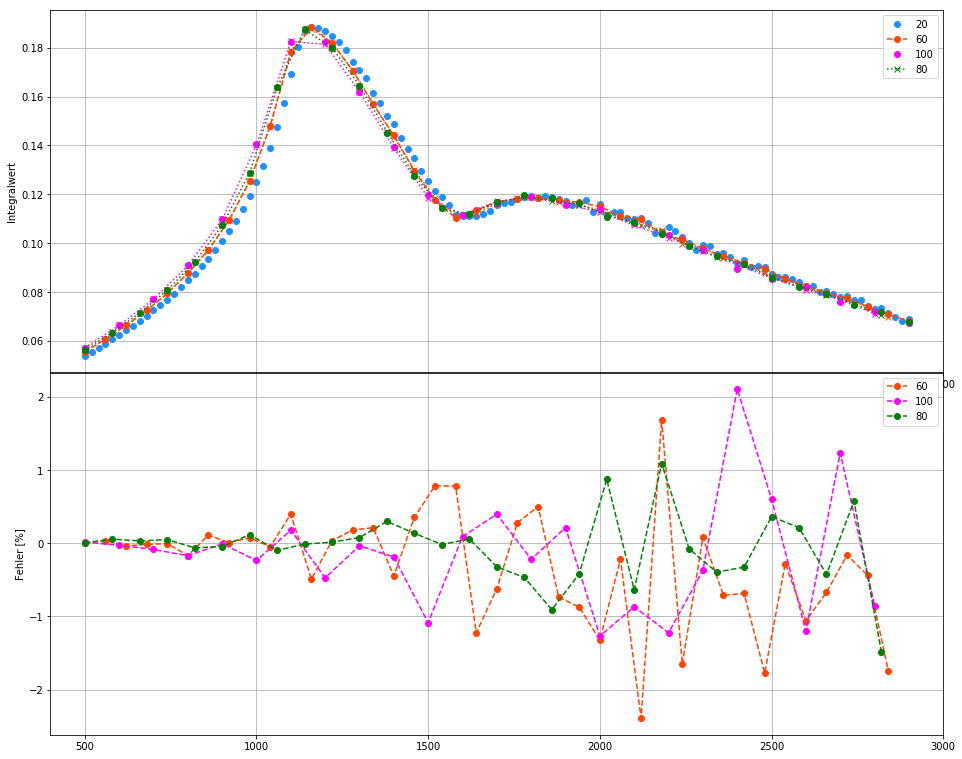

2 2
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


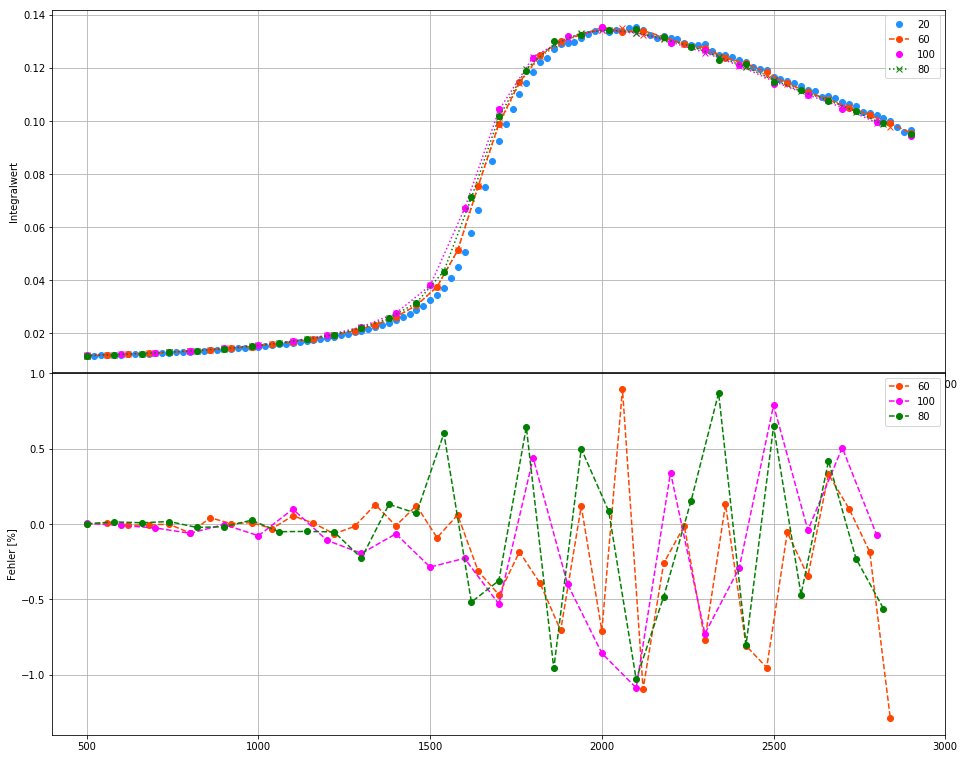

3 0
[1-,0-,0+]=[f0_980_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


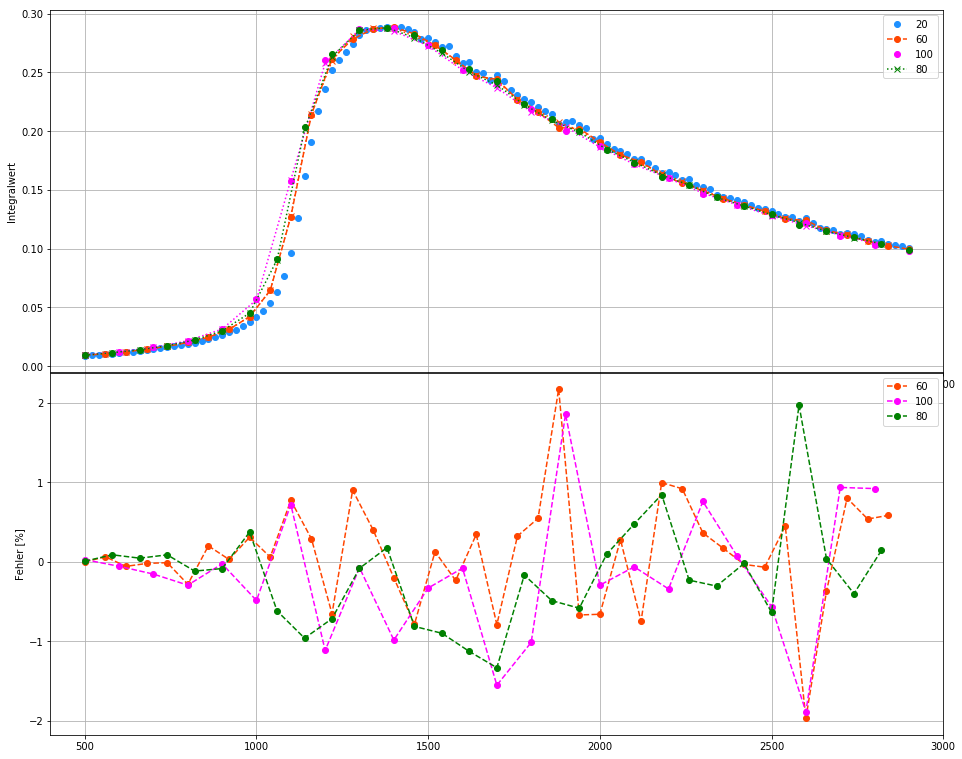

3 1
[1-,0-,0+]=[f0_980_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


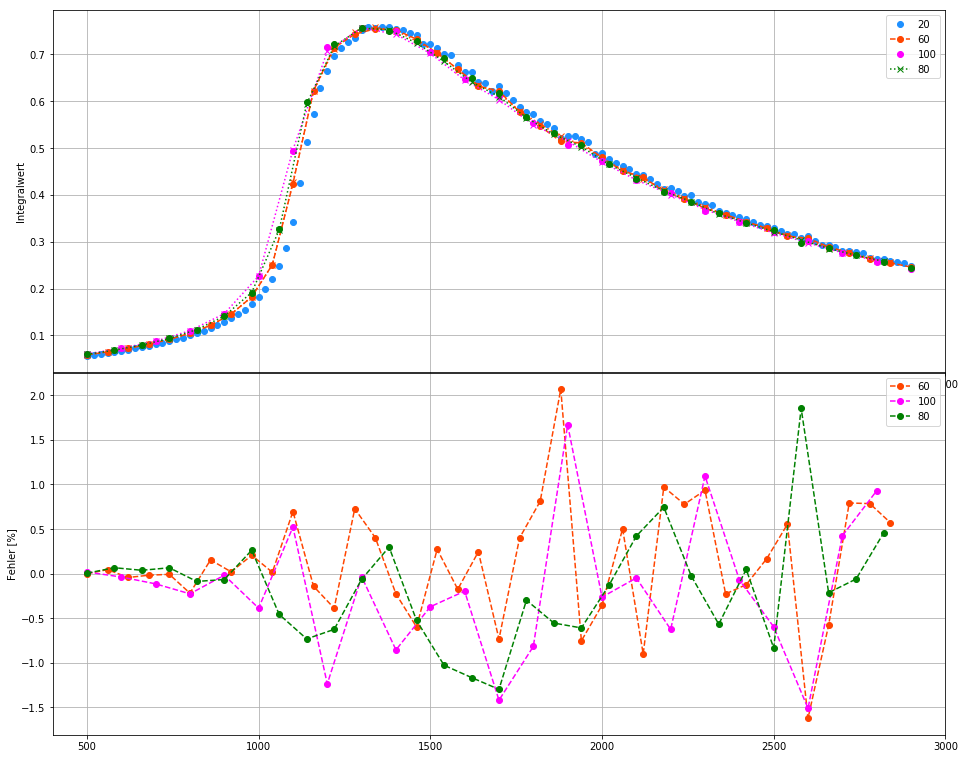

3 2
[1-,0-,0+]=[f0_980_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


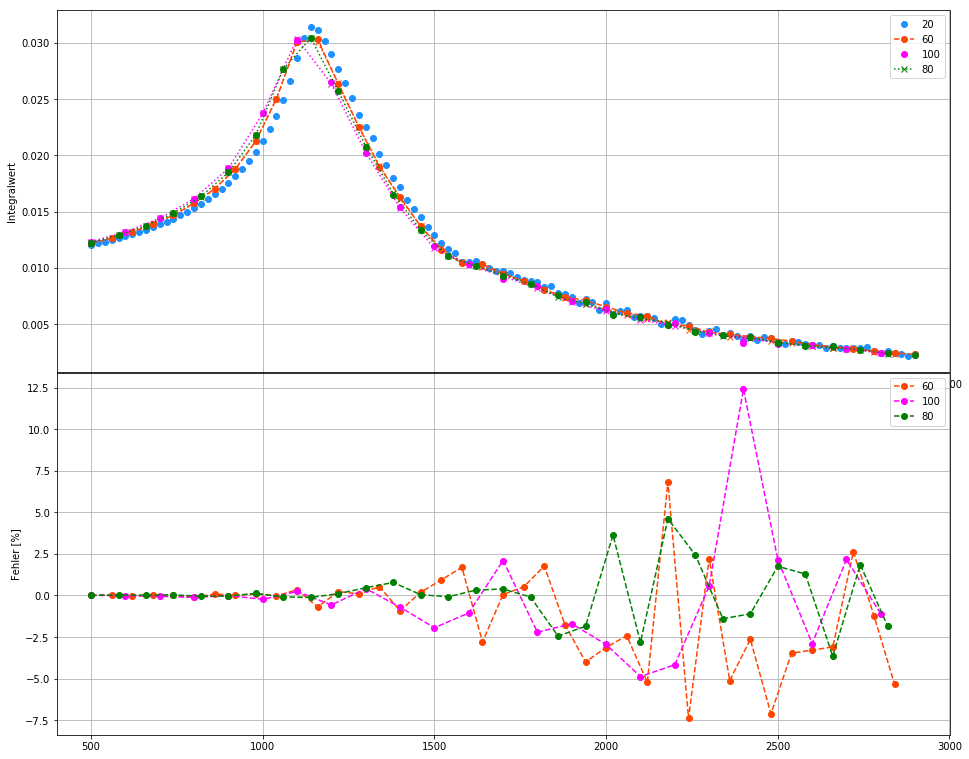

3 3
[1-,0-,0+]=[f0_980_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0_980_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


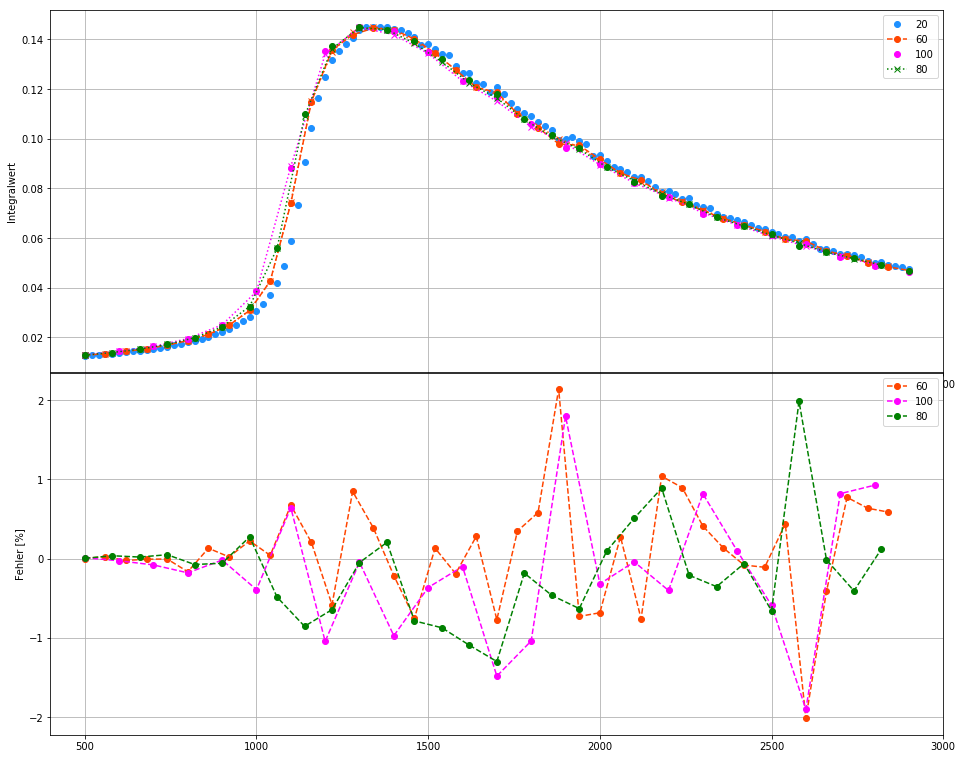

4 0
[1-,0-,0+]=[f2_1270_0=[pi-[2,0]pi+][2,2]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


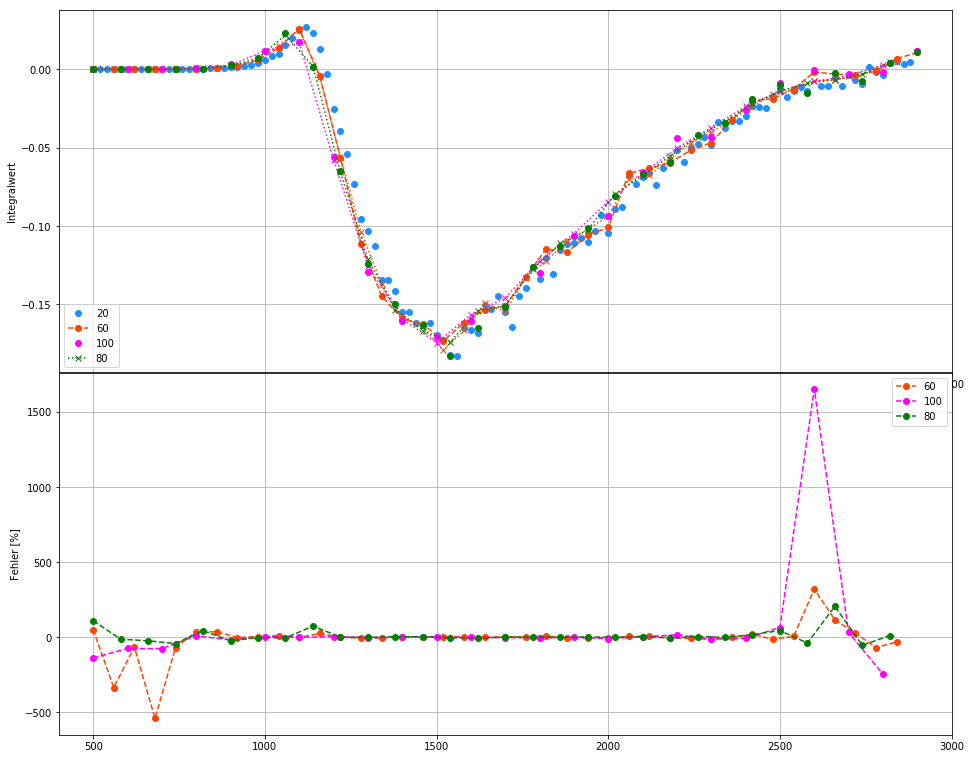

4 1
[1-,0-,0+]=[f2_1270_0=[pi-[2,0]pi+][2,2]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


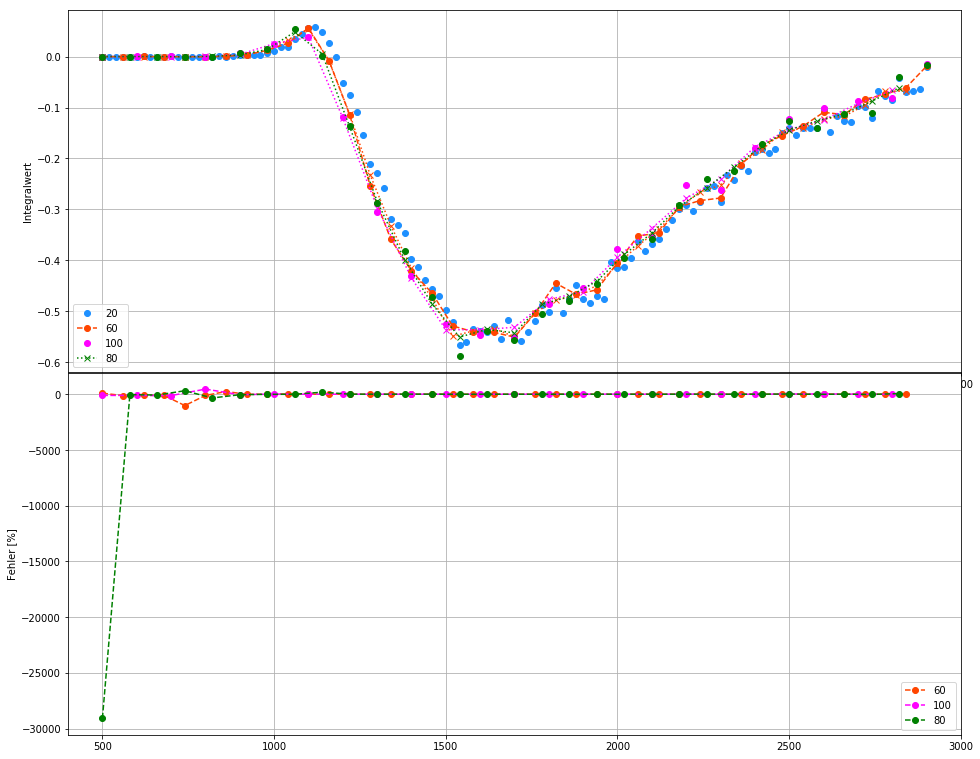

4 2
[1-,0-,0+]=[f2_1270_0=[pi-[2,0]pi+][2,2]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


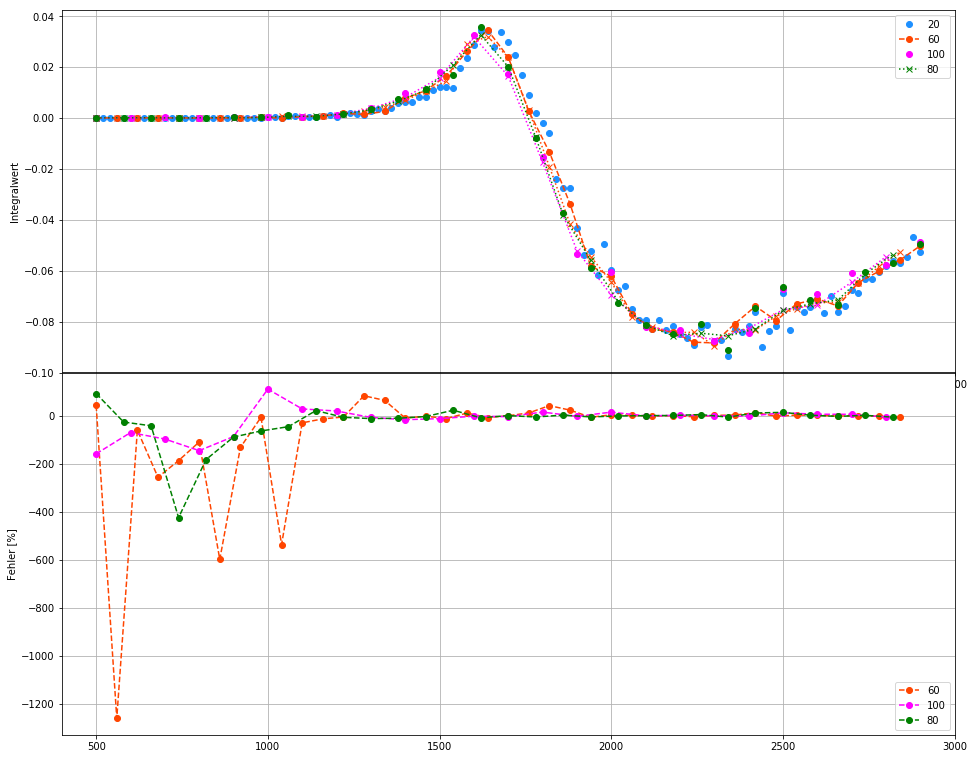

4 3
[1-,0-,0+]=[f2_1270_0=[pi-[2,0]pi+][2,2]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0_980_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


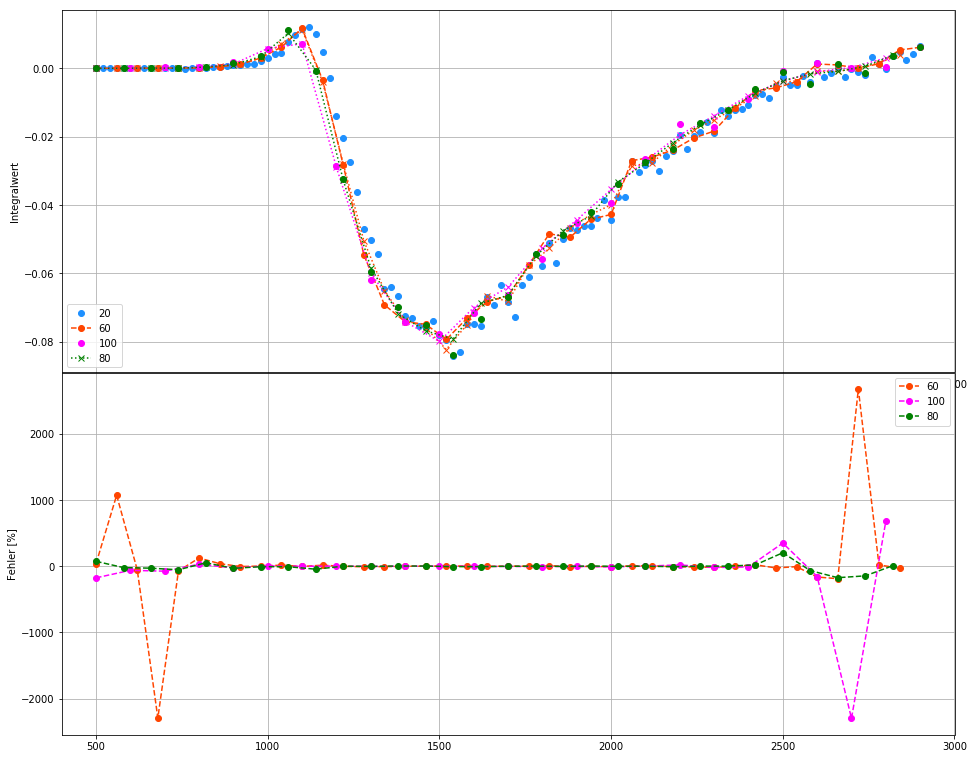

4 4
[1-,0-,0+]=[f2_1270_0=[pi-[2,0]pi+][2,2]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f2_1270_0=[pi-[2,0]pi+][2,2]pi-]_eventFileId-0_2.root


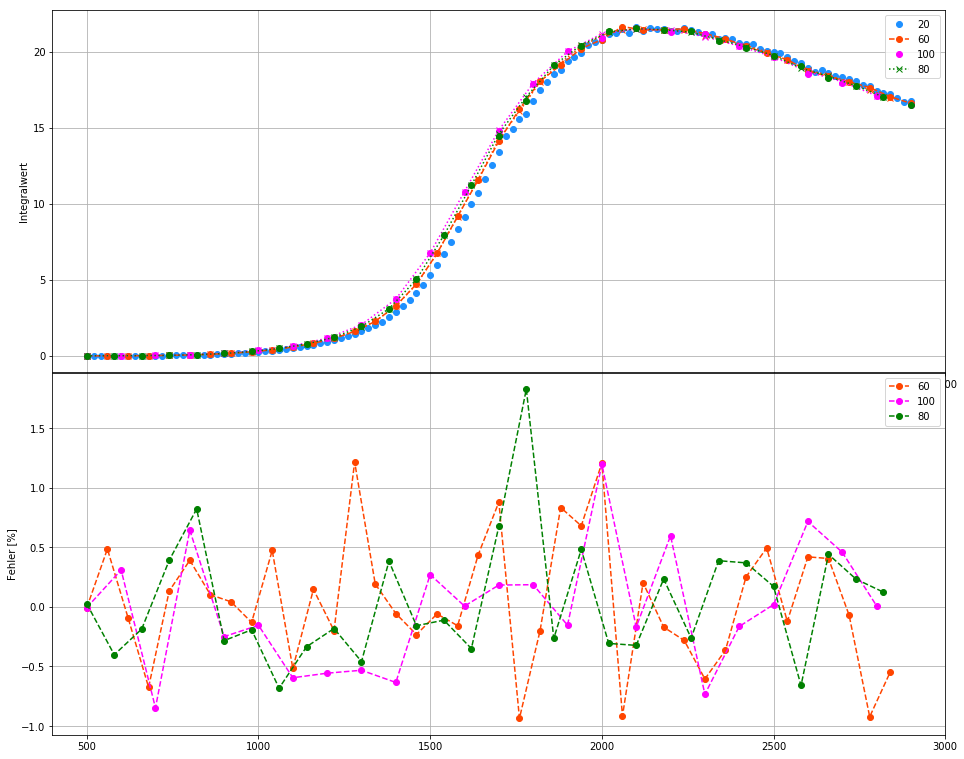

5 0
[1-,0-,0+]=[piPiSWaveAuMorganPenningtonKachaev[sigma0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


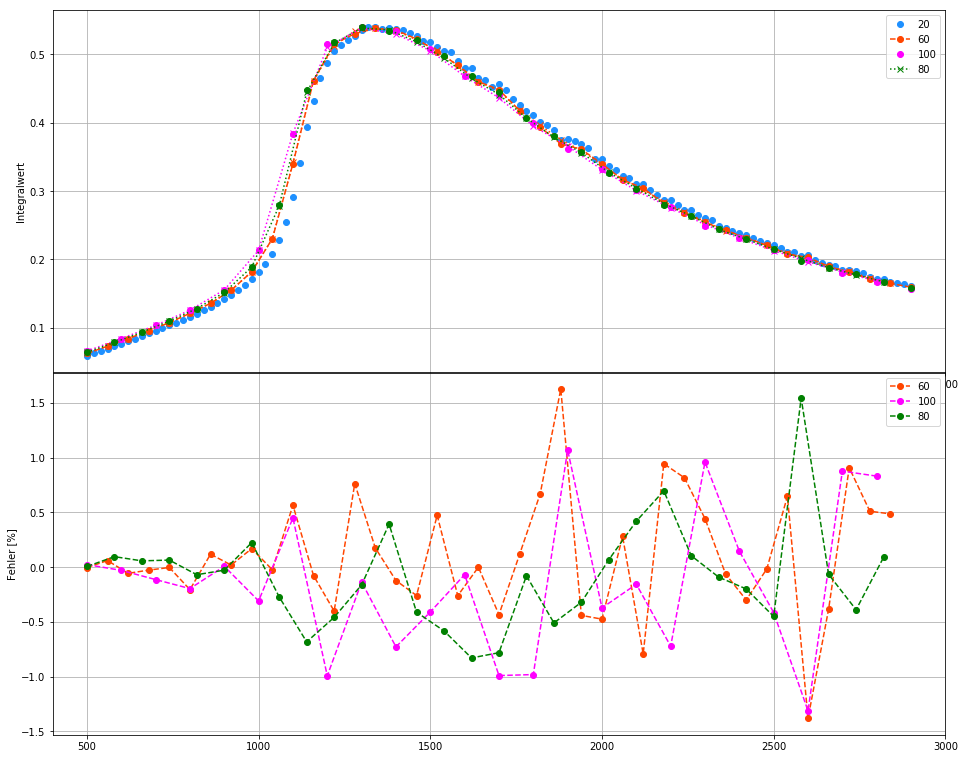

5 1
[1-,0-,0+]=[piPiSWaveAuMorganPenningtonKachaev[sigma0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


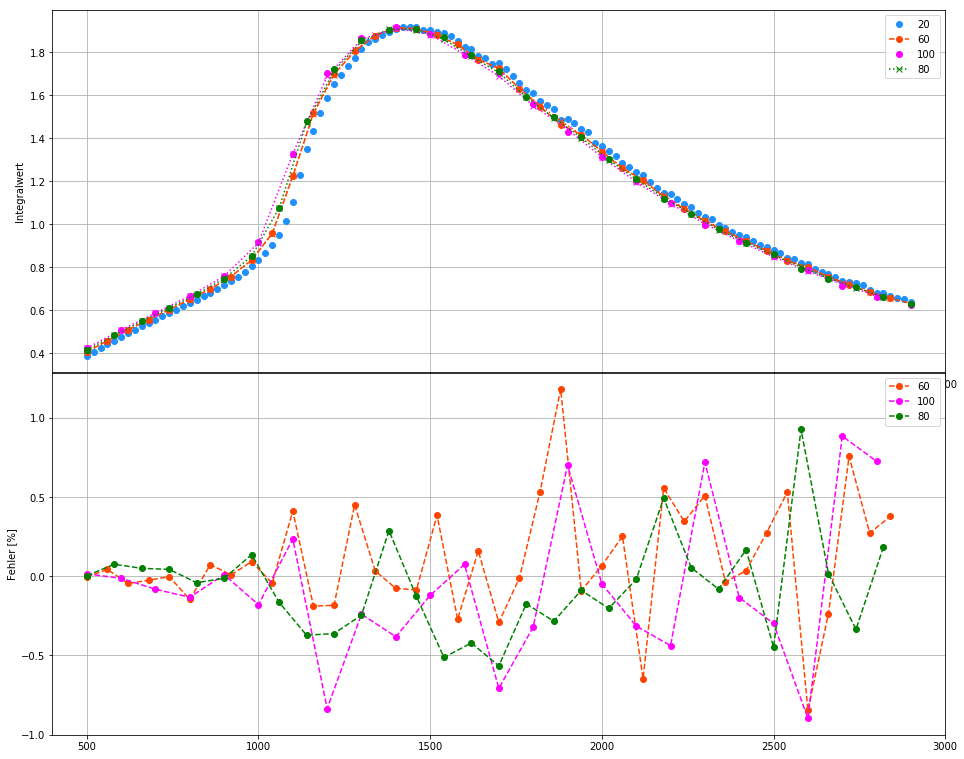

5 2
[1-,0-,0+]=[piPiSWaveAuMorganPenningtonKachaev[sigma0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


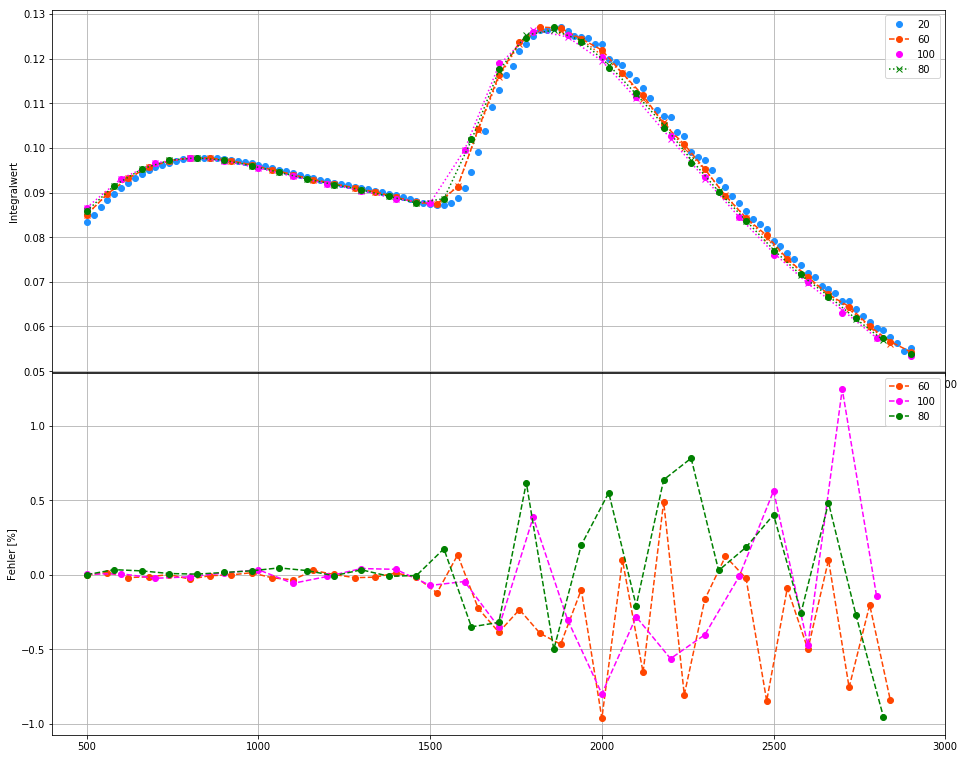

5 3
[1-,0-,0+]=[piPiSWaveAuMorganPenningtonKachaev[sigma0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0_980_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


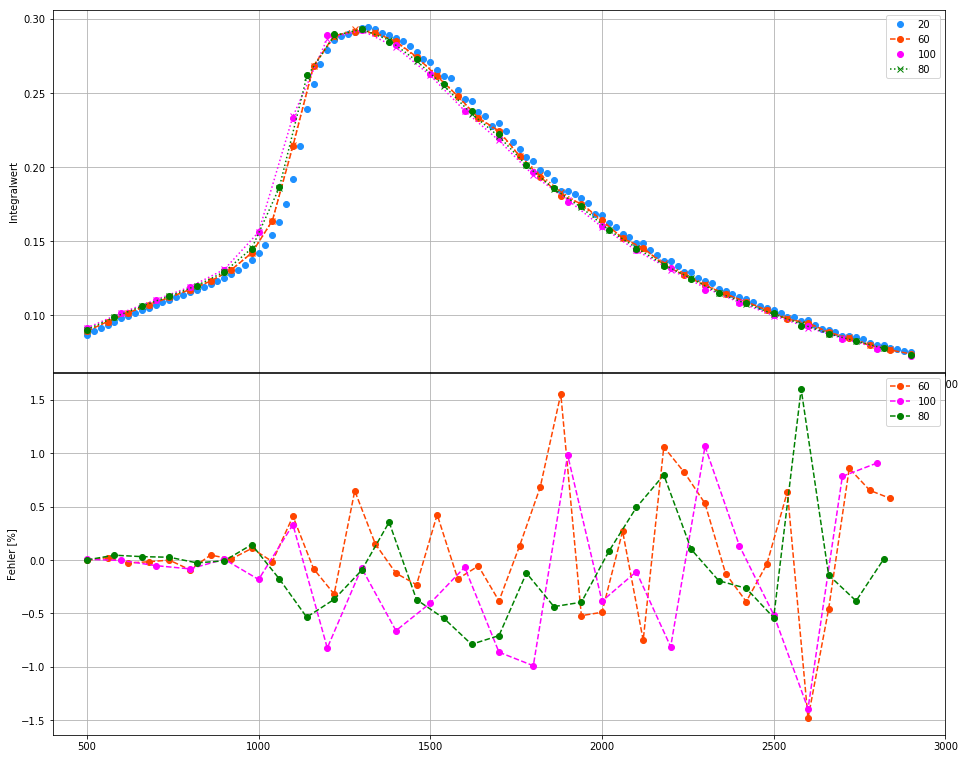

5 4
[1-,0-,0+]=[piPiSWaveAuMorganPenningtonKachaev[sigma0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f2_1270_0=[pi-[2,0]pi+][2,2]pi-]_eventFileId-0_2.root


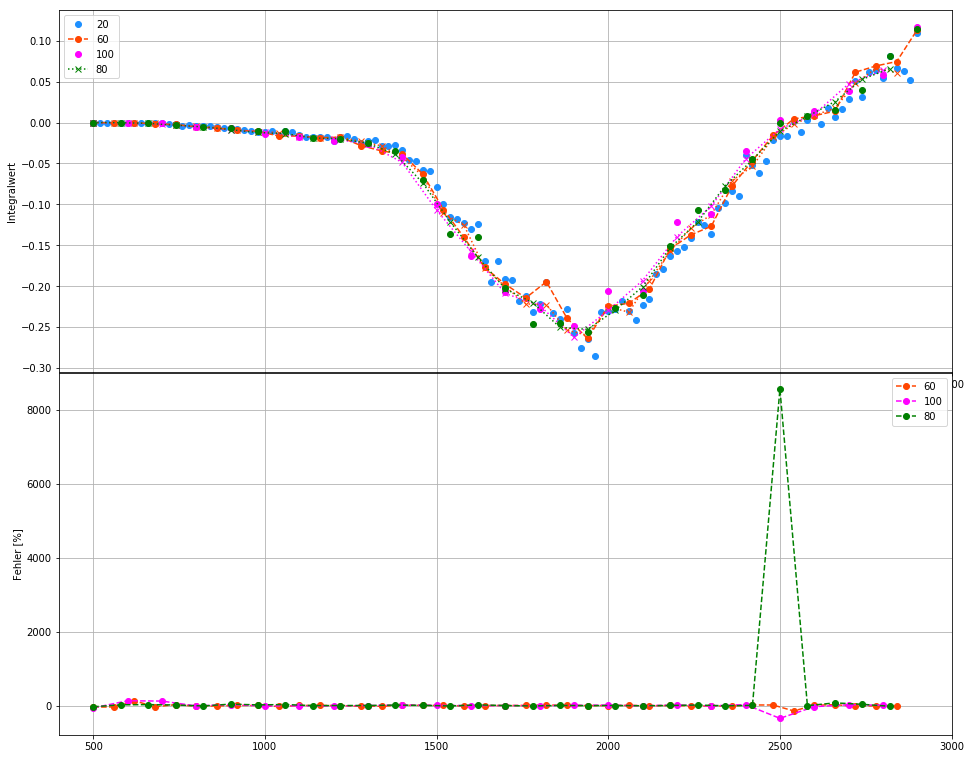

5 5
[1-,0-,0+]=[piPiSWaveAuMorganPenningtonKachaev[sigma0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[piPiSWaveAuMorganPenningtonKachaev[sigma0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


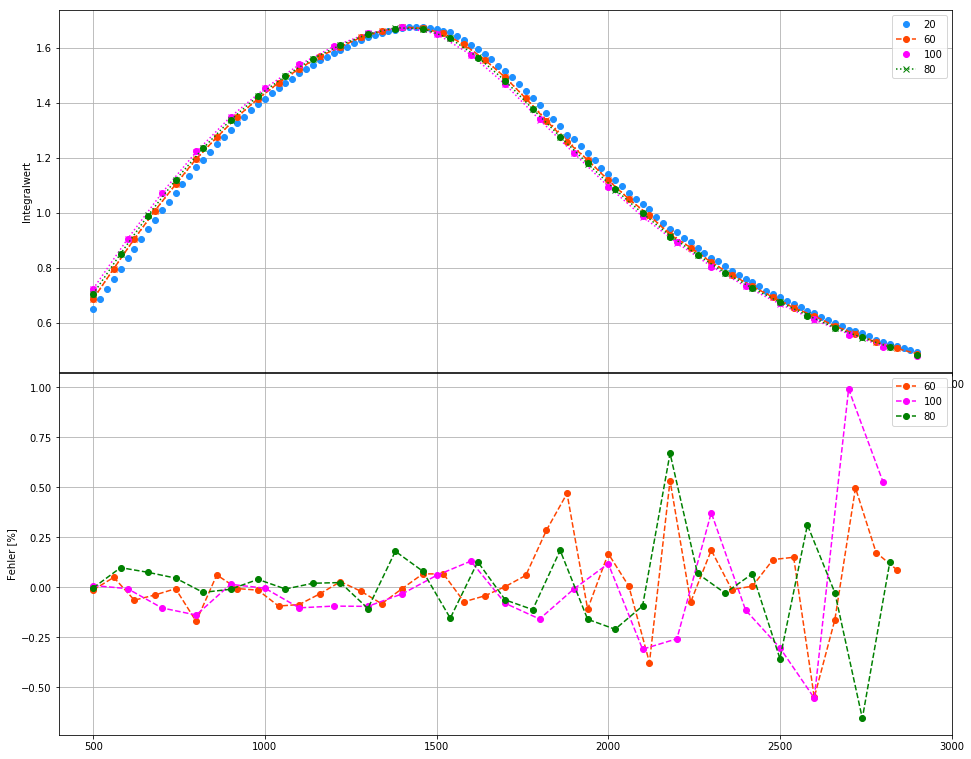

In [38]:
if calcValues == False:
    
    matrix20 = integralMatrix
    matrix60 = integralMatrix1
    matrix100 = integralMatrix2
    matrix80 = integralMatrix3
    
    xmin = min(axisArr20)-100; xmax = max(axisArr20)+100
    #xmin = 400; xmax = 800
    
    
    for i in range(0,6):#len(errorMatrixAbsolut)):
        for j in range(0, i+1):
            print i, j
            print onlyfiles[i]
            print onlyfiles[j]
            
            f = plt.figure(figsize=(16,20))
            plt.subplots_adjust(hspace=0.001)
            
            ax1 = plt.subplot(311)
            ax1.grid(True)     
            ax1.set_xlim(xmin, xmax)
            #ax1.set_ylim(-.00002, .000075)
            #ax1.set_xticks([])
            ax1.set_ylabel('Integralwert')
            
                       
            #axisArr60Interpoliert = axisArr60[:-1]
            #matrix60Interpoliert = np.zeros(len(matrix20[i,j])/3)

            #for k in range(0, len(matrix20[i,j])/3):
            #    matrix60Interpoliert[k] = (matrix20[i,j][3*k].real + matrix20[i,j][3*k+1].real + matrix20[i,j][3*k+2].real)/3
            
            
            axisArr60Interpoliert, matrix60Interpoliert = calcMatrixFromFineToRough(axisArr60, matrix20, 3)
            axisArr100Interpoliert, matrix100Interpoliert = calcMatrixFromFineToRough(axisArr100, matrix20, 5)
            axisArr80Interpoliert, matrix80Interpoliert = calcMatrixFromFineToRough(axisArr80, matrix20, 4)
                       
            axisArr100Interpoliert = axisArr100[:-1]
            matrix100Interpoliert = np.zeros(len(matrix20[i,j])/5)
            for k in range(0, len(matrix20[i,j])/5):
                matrix100Interpoliert[k] = (matrix20[i,j][5*k].real + matrix20[i,j][5*k+1].real + matrix20[i,j][5*k+2].real + matrix20[i,j][5*k+3].real + matrix20[i,j][5*k+4].real)/5
            axisArr80Interpoliert = axisArr80[:-1]
            matrix80Interpoliert = np.zeros(len(matrix20[i,j])/4)
            for k in range(0, len(matrix20[i,j])/4):
                matrix80Interpoliert[k] = (matrix20[i,j][4*k].real + matrix20[i,j][4*k+1].real + matrix20[i,j][4*k+2].real + matrix20[i,j][4*k+3].real)/4


            ax1.plot(axisArr20,  matrix20[i][j].real,  'o', color='dodgerblue', label='20')
            ax1.plot(axisArr60, matrix60[i][j].real, 'o--', color='orangered', label='60')
            ax1.plot(axisArr60Interpoliert,  matrix60Interpoliert.real,  'x:', color='orangered');
            
            ax1.plot(axisArr100, matrix100[i][j].real, 'o', color='fuchsia', label='100')
            ax1.plot(axisArr100Interpoliert,  matrix100Interpoliert.real,  'x:', color='fuchsia')
            
            ax1.plot(axisArr80, matrix80[i][j].real, 'o', color='green')
            ax1.plot(axisArr80Interpoliert,  matrix80Interpoliert.real,  'x:', color='green', label='80')

            #ax1.plot(axisArr100, matrix100[i][j].real, 'o--', color='fuchsia')
            #ax1.plot(axisArr80, matrix80[i][j].real, 'o--', color='green')
            ax1.legend();

            

            ax2 = plt.subplot(312, sharex=ax1)
            ax2.grid(True)
            ax2.set_xlim(xmin, xmax)
            ax2.set_ylabel('Fehler [%]')
            ax2.plot(axisArr60Interpoliert,  100 * (matrix60Interpoliert.real  - matrix60[i,j][:-1].real)/matrix60[i,j][:-1].real, 'o--', color='orangered', label='60')
            ax2.plot(axisArr100Interpoliert, 100 * (matrix100Interpoliert.real - matrix100[i,j][:-1].real)/matrix100[i,j][:-1].real, 'o--', color='fuchsia', label='100')
            ax2.plot(axisArr80Interpoliert,  100 * (matrix80Interpoliert.real  - matrix80[i,j][:-1].real)/matrix80[i,j][:-1].real, 'o--', color='green', label='80')
            ax2.legend()
            
            plt.show()
            
            

### Grundlage 1 MeV Bin

0 0
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


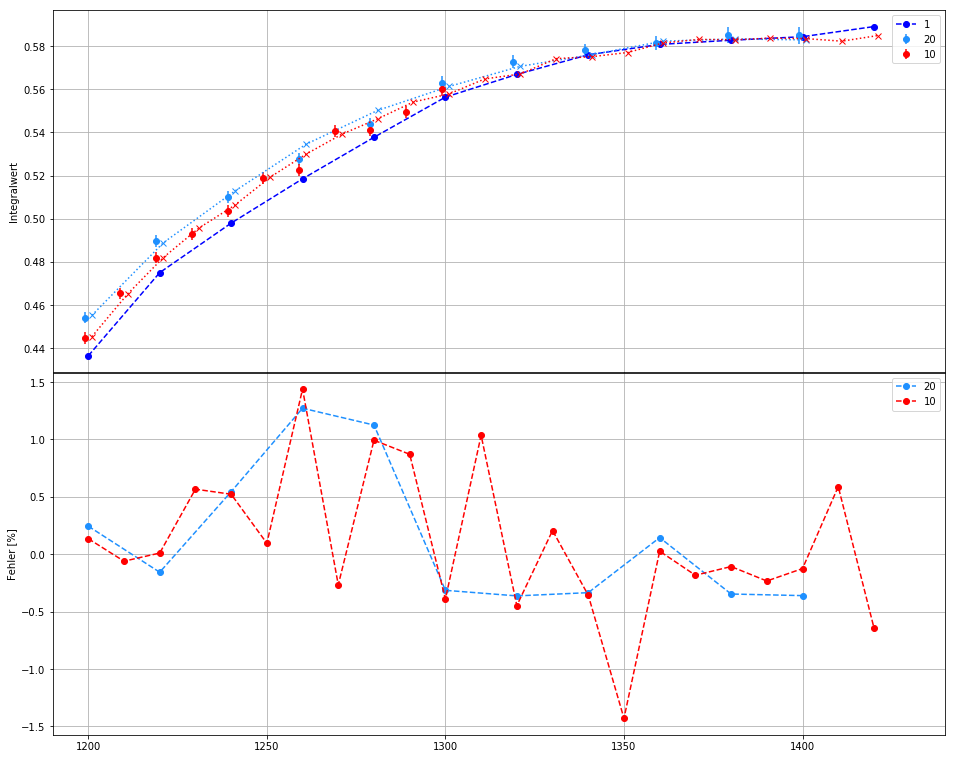

1 0
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


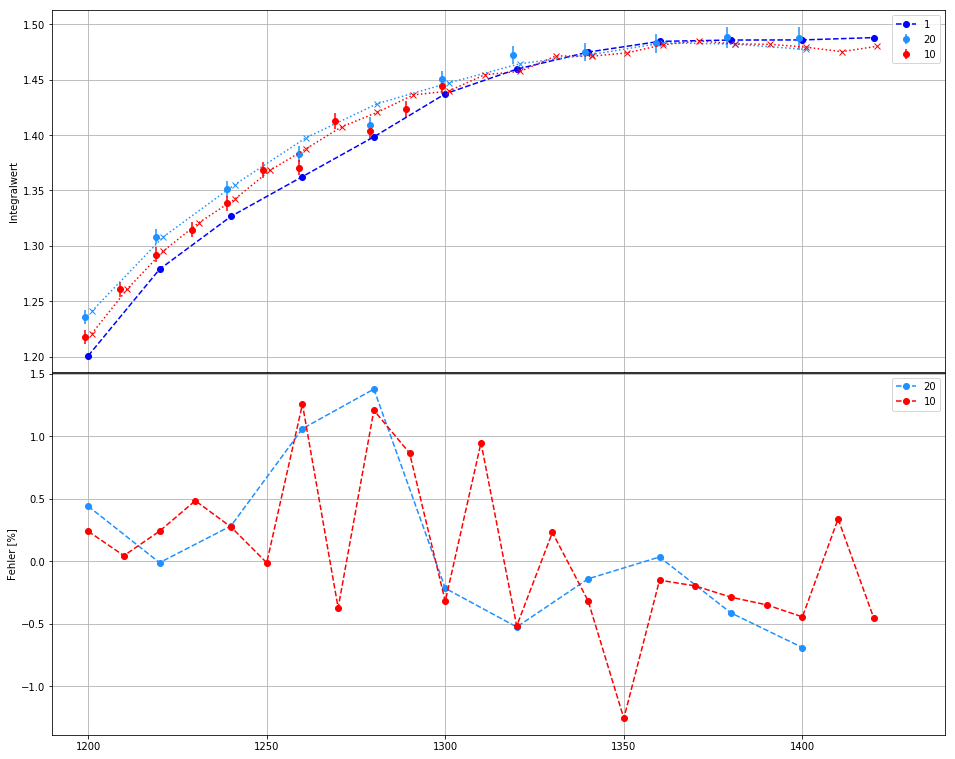

1 1
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


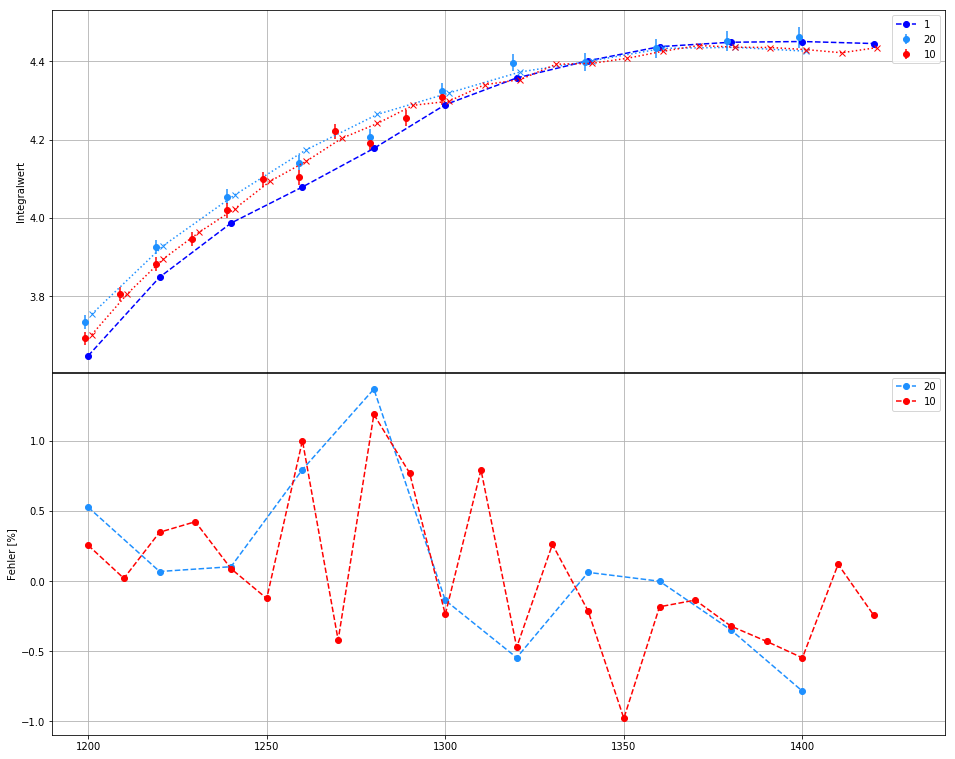

2 0
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980BreitWigner[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


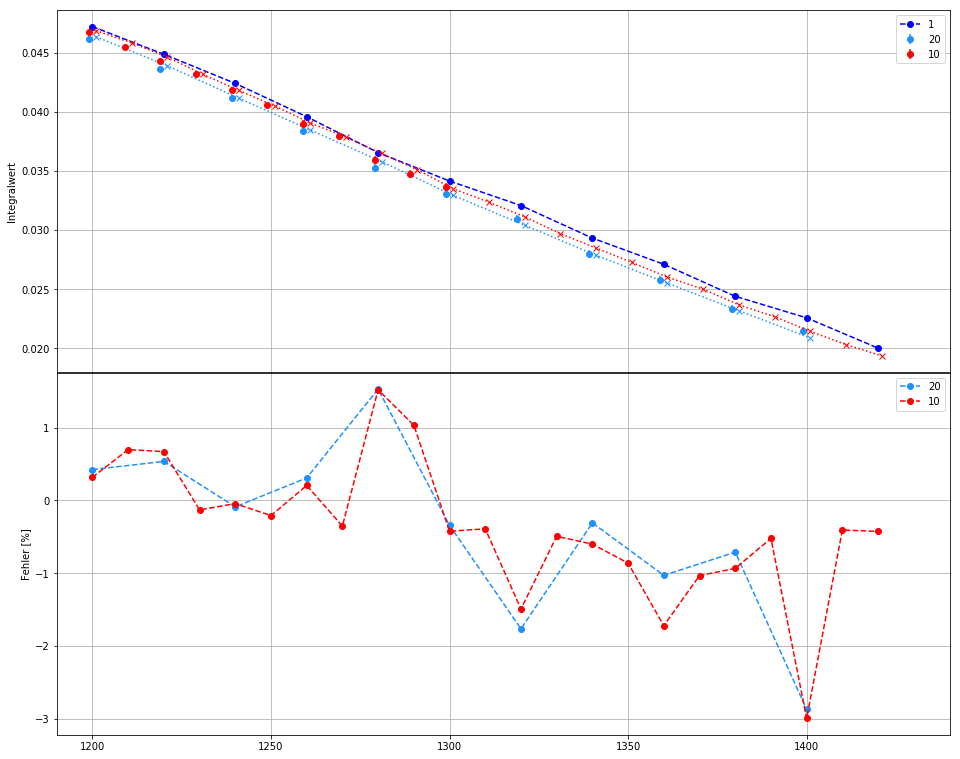

2 1
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0980FlatteBesII[f0_980_0]=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


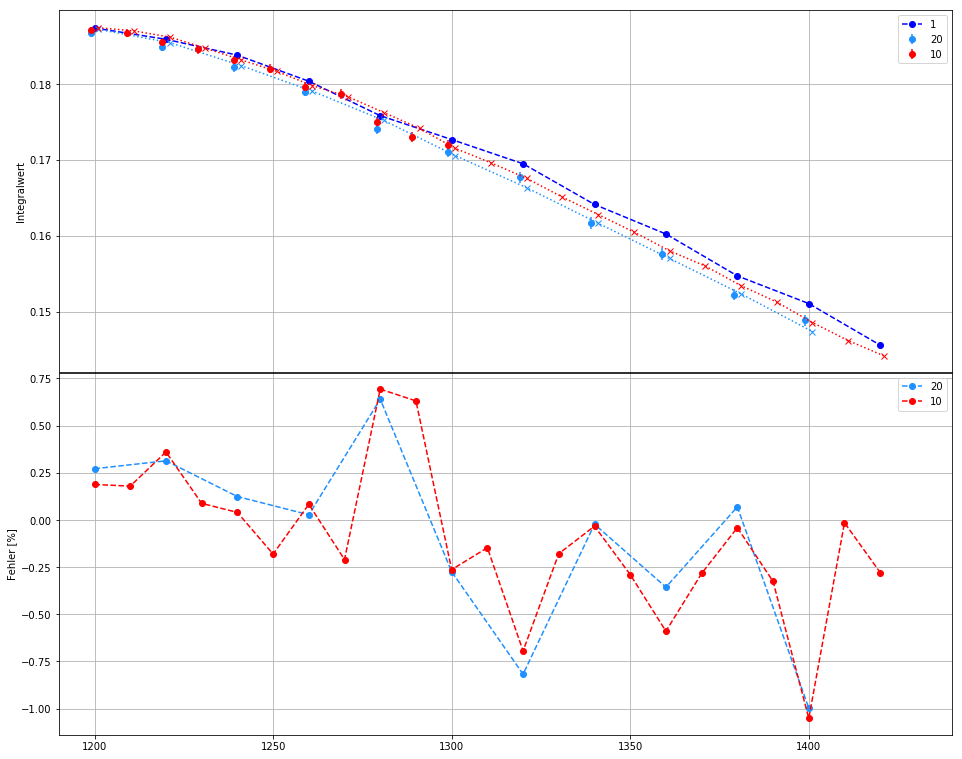

2 2
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root
[1-,0-,0+]=[f0_1500_0=[pi-[0,0]pi+][0,0]pi-]_eventFileId-0_2.root


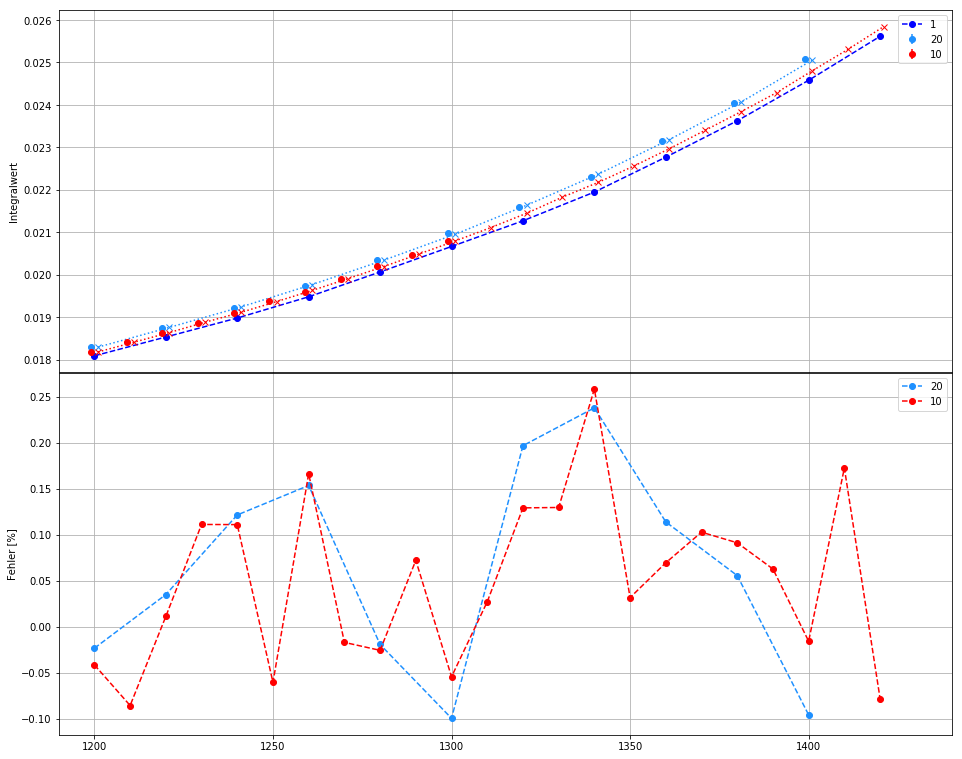

In [62]:
matrix20 = integralMatrix
matrix60 = integralMatrix1
matrix100 = integralMatrix2
matrix80 = integralMatrix3
matrix1 = integralMatrix4
matrix10 = integralMatrix5

errorMatrixAbsolut1 = errorMatrixAbsolut4
errorMatrixAbsolut10 = errorMatrixAbsolut5
errorMatrixAbsolut20 = errorMatrixAbsolut



xmin = min(axisArr1)-10; xmax = max(axisArr1)+10
#xmin = 400; xmax = 1900


for i in range(0,3):#len(errorMatrixAbsolut)):
    for j in range(0, i+1):
        print i, j
        print onlyfiles[i]
        print onlyfiles[j]

        f = plt.figure(figsize=(16,20))
        plt.subplots_adjust(hspace=0.001)

        ax1 = plt.subplot(311)
        ax1.grid(True)     
        ax1.set_xlim(xmin, xmax)
        #ax1.set_xticks([])
        ax1.set_ylabel('Integralwert')


        #calcMatrixFromFineToRough(origAxisArr, origMatrix, nmb)
        axisArr20Interpoliert, matrix20Interpoliert, matrix20ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr20[35:47], matrix1, errorMatrixAbsolut1.real, 20)
        #axisArr60Interpoliert, matrix60Interpoliert = calcMatrixFromFineToRough(axisArr60, matrix1, 60)
        axisArr10Interpoliert, matrix10Interpoliert, matrix10ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr10[70:94], matrix1, errorMatrixAbsolut1.real, 10)
        #axisArr100Interpoliert, matrix100Interpoliert = calcMatrixFromFineToRough(axisArr100, matrix1, 100)
        #axisArr80Interpoliert, matrix80Interpoliert = calcMatrixFromFineToRough(axisArr80, matrix1, 80)

        ax1.plot(axisArr1[::20],  matrix1[i][j][::20].real,  'o--', color='blue', label='1')
        ax1.errorbar(axisArr20[35:46]-1,  matrix20[i][j][35:46].real, marker='o', linestyle = 'None', yerr = errorMatrixAbsolut20[i,j][35:46].real, color='dodgerblue', label='20')
        ax1.errorbar(axisArr20Interpoliert+1,  matrix20Interpoliert.real,  marker = 'x', linestyle = ':', yerr = matrix20ErrorAbsolutInterpoliert, color='dodgerblue');

        ax1.errorbar(axisArr10[70:81]-1,  matrix10[i][j][70:81].real,  marker='o', linestyle='None', yerr = errorMatrixAbsolut10[i,j][70:81].real, color='red', label='10')
        ax1.errorbar(axisArr10Interpoliert+1,  matrix10Interpoliert.real,  marker='x', linestyle=':', yerr = matrix10ErrorAbsolutInterpoliert, color='red');
        '''
        ax1.plot(axisArr60, matrix60[i][j].real, 'o--', color='fuchsia', label='100')
        ax1.plot(axisArr100Interpoliert,  matrix100Interpoliert.real,  'o:', color='fuchsia')

        ax1.plot(axisArr60, matrix60[i][j].real, 'o--', color='green')
        ax1.plot(axisArr80Interpoliert,  matrix80Interpoliert.real,  'o:', color='green', label='80')
        '''
        #ax1.plot(axisArr100, matrix100[i][j].real, 'o--', color='fuchsia')
        #ax1.plot(axisArr80, matrix80[i][j].real, 'o--', color='green')
        ax1.legend();



        ax2 = plt.subplot(312, sharex=ax1)
        ax2.grid(True)
        ax2.set_xlim(xmin, xmax)
        ax2.set_ylabel('Fehler [%]')
        ax2.plot(axisArr20Interpoliert, 100 * (matrix20Interpoliert.real - matrix20[i,j][35:46].real)/matrix20[i,j][35:46].real, 'o--', color='dodgerblue', label='20')
        ax2.plot(axisArr10Interpoliert, 100 * (matrix10Interpoliert.real - matrix10[i,j][70:93].real)/matrix10[i,j][70:93].real, 'o--', color='red', label='10')
        ax2.legend()

        plt.show()



In [64]:
print len(errorMatrixAbsolut1[0,0]), len(matrix1[0,0]), len(axisArr1)
print errorMatrixAbsolut1[2,2]
print matrix10ErrorAbsolutInterpoliert

231 231 231
[1.31001856e-05+0.j 1.31234812e-05+0.j 1.32415277e-05+0.j
 1.32960720e-05+0.j 1.33149099e-05+0.j 1.33743972e-05+0.j
 1.34181938e-05+0.j 1.34712956e-05+0.j 1.35388056e-05+0.j
 1.35581243e-05+0.j 1.36553851e-05+0.j 1.37115525e-05+0.j
 1.37409114e-05+0.j 1.38102271e-05+0.j 1.39117308e-05+0.j
 1.38554439e-05+0.j 1.39956162e-05+0.j 1.39819672e-05+0.j
 1.41072841e-05+0.j 1.41567697e-05+0.j 1.42150540e-05+0.j
 1.42556531e-05+0.j 1.43614266e-05+0.j 1.43566982e-05+0.j
 1.44538059e-05+0.j 1.45077392e-05+0.j 1.45690318e-05+0.j
 1.45698207e-05+0.j 1.46452479e-05+0.j 1.47550148e-05+0.j
 1.47826968e-05+0.j 1.49190077e-05+0.j 1.49787925e-05+0.j
 1.50625030e-05+0.j 1.50510561e-05+0.j 1.51681416e-05+0.j
 1.51740617e-05+0.j 1.53257157e-05+0.j 1.53195651e-05+0.j
 1.54190714e-05+0.j 1.54807884e-05+0.j 1.56099992e-05+0.j
 1.56047192e-05+0.j 1.56959535e-05+0.j 1.57436098e-05+0.j
 1.57771429e-05+0.j 1.58354547e-05+0.j 1.59372225e-05+0.j
 1.59995254e-05+0.j 1.61030856e-05+0.j 1.61622433e-05+0.j
 1

ValueError: need more than 1 value to unpack

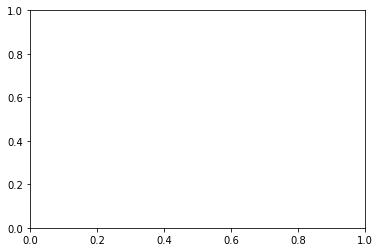

In [65]:
plt.pcolormesh(np.arange(0, len(errorMatrixAbsolut)), np.arange(0, len(errorMatrixAbsolut)), z)
#plt.xlabel('x')
#plt.ylabel('y')
#plt.title('Pseudocolor Mesh (NumPy-Matplotlib)')

# Plot colorbar for color mesh
cbar = plt.colorbar()
#cbar.set_ticks([0.33, 1., 1.67])
#cbar.set_ticklabels(['Cat 0', 'Cat 1', 'Cat 2'])
plt.show()

d
d
d
d


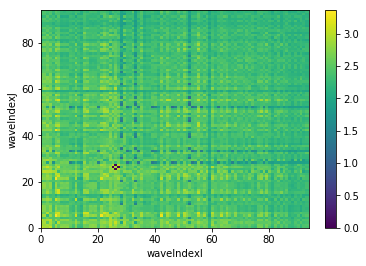

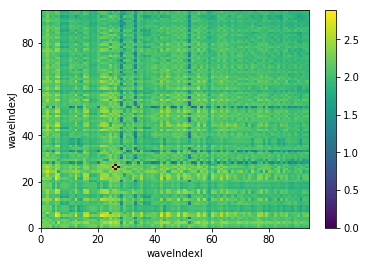

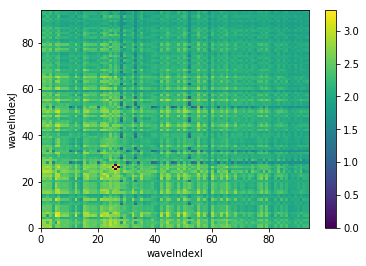

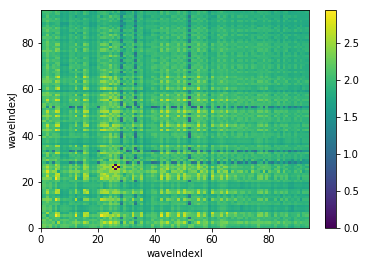

In [157]:
matrix20 = integralMatrix
matrix60 = integralMatrix1
matrix100 = integralMatrix2
matrix80 = integralMatrix3
matrix1 = integralMatrix4
matrix10 = integralMatrix5

errorMatrixAbsolut1 = errorMatrixAbsolut4
errorMatrixAbsolut10 = errorMatrixAbsolut5
errorMatrixAbsolut20 = errorMatrixAbsolut

nmbWaves = len(errorMatrixAbsolut10)
ratio10Max = np.zeros((nmbWaves, nmbWaves))
ratio20Max = np.zeros((nmbWaves, nmbWaves))
ratio10Min = np.zeros((nmbWaves, nmbWaves))
ratio20Min = np.zeros((nmbWaves, nmbWaves))

iEnd = len(errorMatrixAbsolut1)
jEnd = len(errorMatrixAbsolut1)

for i in range(0,iEnd):
    z20 = np.zeros((jEnd,11))
    z10 = np.zeros((jEnd,23))

    for j in range(0,jEnd):
        axisArr20Interpoliert, matrix20Interpoliert, matrix20ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr20[35:47], matrix1, errorMatrixAbsolut1.real, 20)
        axisArr10Interpoliert, matrix10Interpoliert, matrix10ErrorAbsolutInterpoliert = calcMatrixFromFineToRough(axisArr10[70:94], matrix1, errorMatrixAbsolut1.real, 10)
        
        if i == 25 and j == 26 or i == 26 and j == 25 or i == 26 and j == 27 or i == 27 and j == 26:
            print "d"
        else:
            z20[j] = np.log10(np.abs(((errorMatrixAbsolut20[i,j][35:46].real/matrix20ErrorAbsolutInterpoliert.real))))
            z10[j] = np.log10(np.abs(((errorMatrixAbsolut10[i,j][70:93].real/matrix10ErrorAbsolutInterpoliert.real))))
            ratio10Max[i,j] = np.amax(z10[j])
            ratio10Max[j,i] = np.amax(z10[j])
            ratio20Max[i,j] = np.amax(z20[j])
            ratio20Max[j,i] = np.amax(z20[j])
            ratio10Min[i,j] = np.amin(z10[j])
            ratio10Min[j,i] = np.amin(z10[j])
            ratio20Min[i,j] = np.amin(z20[j])
            ratio20Min[j,i] = np.amin(z20[j])
            
        
    #print ((errorMatrixAbsolut20[i,j][35:46].real/matrix20ErrorAbsolutInterpoliert.real))
    #print np.floor(np.log10(np.abs(((errorMatrixAbsolut20[i,j][35:46].real/matrix20ErrorAbsolutInterpoliert.real))))).astype(int)
    '''
    plt.pcolormesh(np.arange(0, len(z20[0])), np.arange(0, jEnd), z20)
    cbar = plt.colorbar()
    plt.yticks(range(0,jEnd,20))
    plt.ylabel('waveIndexJ')
    plt.show()

    plt.pcolormesh(np.arange(0, len(z10[0])), np.arange(0, jEnd), z10)
    cbar = plt.colorbar()
    plt.yticks(range(0,jEnd,20))
    plt.ylabel('waveIndexJ')
    plt.show()
    '''

plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio10Max)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.show()

plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio10Min)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.show()

plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio20Max)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.show()

plt.pcolormesh(np.arange(0,nmbWaves), np.arange(0,nmbWaves), ratio20Min)
cbar = plt.colorbar()
plt.yticks(range(0,nmbWaves,20))
plt.xlabel('waveIndexI')
plt.ylabel('waveIndexJ')
plt.show()

    

In [141]:
print ((errorMatrixAbsolut20[25,26][35:46].real/matrix20ErrorAbsolutInterpoliert.real))
print np.log10(np.abs(((errorMatrixAbsolut20[25,26][35:46].real/matrix20ErrorAbsolutInterpoliert.real))))
print errorMatrixAbsolut20[i,j][35:46].real
print matrix20ErrorAbsolutInterpoliert.real

[8.32144307e-09 9.13219392e-09 1.08751086e-08 7.98774334e-09
 8.17396304e-09 6.36580473e-09 7.74215200e-09 6.60642388e-09
 5.99769568e-09 7.09505062e-09 5.71199628e-09]
[-8.07980135 -8.03942488 -7.9635664  -8.0975759  -8.08756733 -8.19614669
 -8.11113831 -8.18003356 -8.22201557 -8.1490445  -8.24321208]
[3.30814598e-14 3.11935115e-14 3.06643517e-14 2.89378481e-14
 2.80212765e-14 2.64789254e-14 2.51784628e-14 2.39766331e-14
 2.31338593e-14 2.18387359e-14 2.05398975e-14]
[3.97544747e-06 3.41577410e-06 2.81968234e-06 3.62278141e-06
 3.42811392e-06 4.15955665e-06 3.25212715e-06 3.62929075e-06
 3.85712455e-06 3.07802397e-06 3.59592278e-06]


In [ ]:
# %reset